### 載入所需的Libraries

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List
import nltk

### 載入資料

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# read data from spam.csv
sms_data = pd.read_csv('/content/drive/MyDrive/NLP/spam.csv',encoding = "ISO-8859-1")

sms_data = sms_data[['v1','v2']]
sms_data = sms_data.rename(columns={'v1':'label','v2':'content'})
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# check how many spams and hams
sms_data.groupby("label").count()

,content
label,
ham,4825
spam,747


In [5]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1

sms_data.loc[(sms_data.label=='ham'),'label']=0
sms_data.loc[(sms_data.label=='spam'),'label']=1

sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [6]:
###<your code>###
sms_train, sms_test = train_test_split(sms_data, test_size=0.2, random_state=1, stratify=sms_data['label'])
sms_train = sms_train.reset_index(drop=True)
sms_test = sms_test.reset_index(drop=True)
print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3859
1          598
       content
label         
0          966
1          149


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [8]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
        # make all content to lowercase
        df.loc[i,'content'] = df.loc[i,'content'].lower()

        # remove all punctuations
        df.loc[i,'content'] = ' '.join([w for w in re.findall('[a-z]+',df.loc[i,'content'])])
        
    
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

Train:
  label                                            content
0     0  okay same with me well thanks for the clarific...
1     0                  will b going to esplanade fr home
2     1  reply to win weekly what professional sport do...
3     0                                 shb b ok lor thanx
4     1  private your account statement for shows un re...
Test:
  label                                            content
0     0  dont hesitate you know this is the second time...
1     0         didn t try g and i decided not to head out
2     0  a swt thought nver get tired of doing little t...
3     0  haha awesome i might need to take you up on th...
4     0  no it s not pride i m almost lt gt years old a...


In [9]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7708

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [10]:
vectorizer = TfidfVectorizer(max_features=2000)

vectorizer.fit(x_train)

tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 51200 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12251 stored elements in Compressed Sparse Row format>)

### 建立共現矩陣

In [13]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(len(word2idx), len(word2idx)), dtype=np.int32)
    
    for idx, sms in enumerate(corpus):
        sms = sms.split() #將string轉成list
        sms_ids = [word2idx[word] for word in sms if word in vocab_list] #取得word對應id
        
        for center_i, center_word_id in enumerate(sms_ids): #center i => word在sentence中的位置
                                    #center_word_id => word_id

            left_idx = center_i - window_size if center_i - window_size >= 0 else 0 #找出左邊的字的位置id
            context_ids = sms_ids[left_idx:center_i] #context_ids == cneter_word 最左邊的word_id 到左邊第一個的word_id

            
            for left_i, left_id in enumerate(context_ids): 
  
                co_matrix[center_word_id, left_id] += 1 #left
                co_matrix[left_id, center_word_id] += 1 #前一個的right
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        #if use weighting, then we set the co-occurrence with the word itself to 1.0
        np.fill_diagonal(co_matrix, 1)
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

### 建立PPMI矩陣

In [14]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)    #所有詞出現的總次數
    S = np.sum(co_matrix,axis=0) #每個詞出現的總次數
    total = co_matrix.shape[0] * co_matrix.shape[1]

    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i,j]*N / S[i]*S[j]+eps )
            M[i,j] = max(0,pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

array([[18.115837,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 18.115837,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 18.115837, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 18.115837,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      , 18.115837,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
        18.115837]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.2536797523498535
Number of components = 20 and explained variance = 0.3111409544944763
Number of components = 30 and explained variance = 0.35804226994514465
Number of components = 40 and explained variance = 0.39801397919654846
Number of components = 50 and explained variance = 0.43328583240509033
Number of components = 60 and explained variance = 0.4643353521823883
Number of components = 70 and explained variance = 0.49265992641448975
Number of components = 80 and explained variance = 0.5183805823326111
Number of components = 90 and explained variance = 0.541986882686615
Number of components = 100 and explained variance = 0.5640880465507507
Number of components = 110 and explained variance = 0.5847129821777344
Number of components = 120 and explained variance = 0.6040568947792053
Number of components = 130 and explained variance = 0.6220691800117493
Number of components = 140 and explained variance = 0.639112114906311


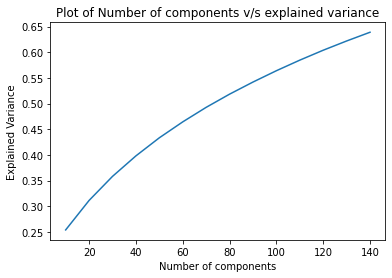

In [19]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim, n_iter=7, random_state=42)
    svd.fit(ppmi_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print(f'Number of components = {dim} and explained variance = {svd.explained_variance_ratio_.sum()}')
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [29]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
n_components = 140
svd = TruncatedSVD(n_components, n_iter=7, random_state=42)
re_co_matrix = svd.fit_transform(ppmi_matrix)

print(f'Number of components = {n_components} and explained variance = {svd.explained_variance_ratio_.sum()}')

Number of components = 140 and explained variance = 0.639112114906311


In [33]:
re_co_matrix.shape

(2000, 140)

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [31]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #每個文字的向量
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 215 doesn't contain word in vocab_list
erutupalam thandiyachu


document 580 doesn't contain word in vocab_list



document 976 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 1051 doesn't contain word in vocab_list
east coast


document 1442 doesn't contain word in vocab_list
audrie lousy autocorrect


document 1652 doesn't contain word in vocab_list
beerage


document 1894 doesn't contain word in vocab_list



document 2222 doesn't contain word in vocab_list
hanks lotsly


document 2553 doesn't contain word in vocab_list
ringtoneking


document 2875 doesn't contain word in vocab_list
u


document 2993 doesn't contain word in vocab_list
k k congratulation


document 3421 doesn't contain word in vocab_list
g w r


document 4152 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 47 doesn't contain word in vocab_list
tf p


document 58 doesn't contain word in vocab_list
received understood n acted upon


In [48]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(doc_vec_train, y_train_filter)
train_pred = neigh.predict(doc_vec_train)
# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = neigh.predict(doc_vec_test)

In [49]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"test acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9797479747974798
test acc: 0.9657965796579658
